# Beijing Air Quality Forecasting Starter Notebook

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf

In [8]:
# Load the datasets
# Ensure train.csv and test.csv are saved in your Google Drive in the same folder.
# Replace the file paths below with the actual paths to your dataset.
train = pd.read_csv('../Datasets/train.csv')
test = pd.read_csv('../Datasets/test.csv')


# Explore the training data

In this sections explore your dataset with appropiate statistics and visualisations to understand your better. Ensure that you explain output of every code cell and what it entails.

Summary statistics:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
count,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000
mean,15338.500000,-0.029431,-0.062712,0.013612,0.030542,0.016992,0.011253,0.016193,0.005833,-0.025008,100.793427
std,8855.542765,0.994087,1.015193,1.008991,1.018337,1.087278,1.063811,1.006001,1.001847,0.982122,90.180732
min,1.000000,-2.135153,-2.578070,-2.380821,-0.468688,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,0.000000
25%,7669.750000,-0.888034,-0.938521,-0.822670,-0.441894,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,32.000000
50%,15338.500000,-0.056622,0.045209,-0.043595,-0.352512,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,81.000000
75%,23007.250000,0.913358,0.864984,0.832865,0.005216,-0.069353,-0.137667,1.448138,1.366085,-0.522096,135.000000
max,30676.000000,1.814055,2.340578,2.877939,11.231956,35.439859,25.288745,1.448138,1.366085,1.915355,994.000000


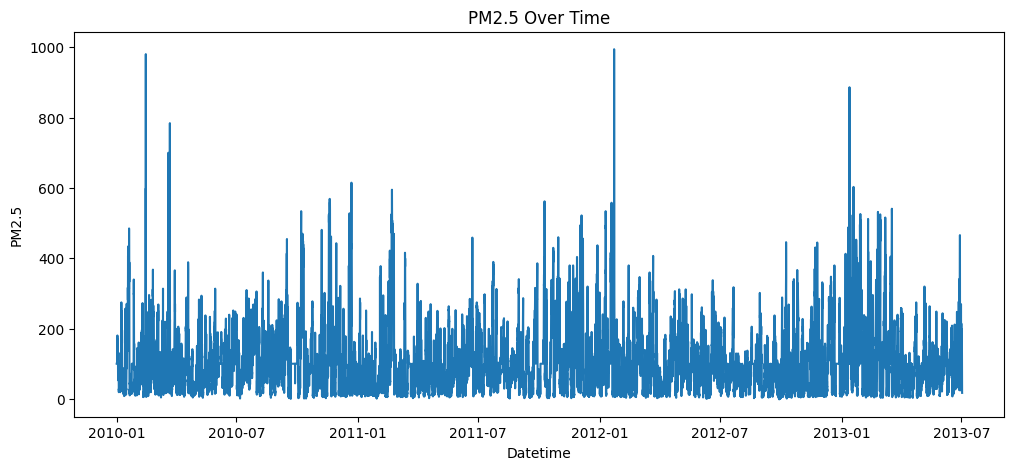

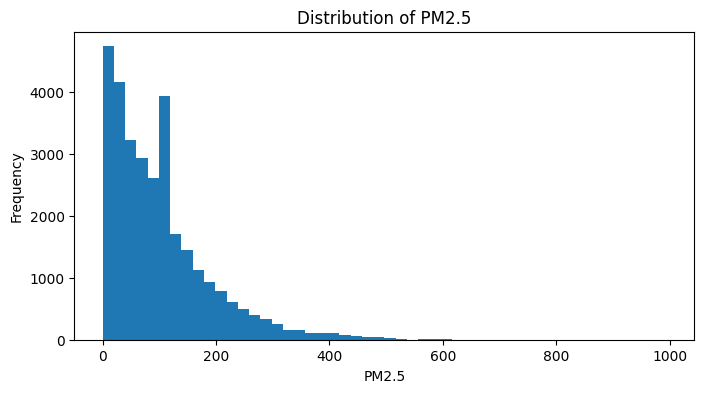

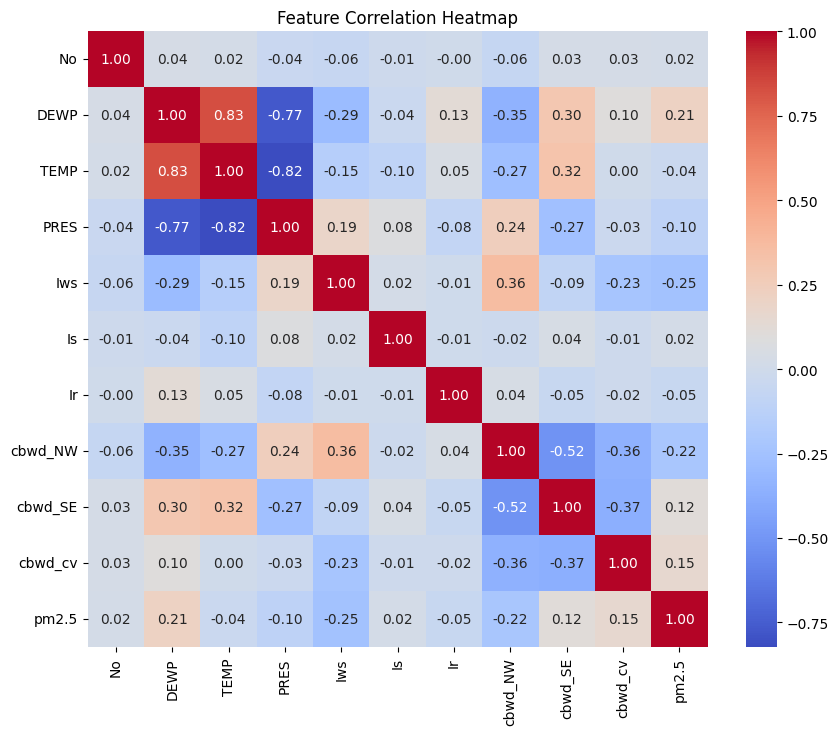

In [20]:
# Data Exploration: Summary statistics and visualizations

# Summary statistics
print("Summary statistics:")
display(train.describe())

# Plot PM2.5 over time
plt.figure(figsize=(12, 5))
plt.plot(train.index, train['pm2.5'])
plt.title('PM2.5 Over Time')
plt.xlabel('Datetime')
plt.ylabel('PM2.5')
plt.show()

# Histogram of PM2.5
plt.figure(figsize=(8, 4))
plt.hist(train['pm2.5'], bins=50)
plt.title('Distribution of PM2.5')
plt.xlabel('PM2.5')
plt.ylabel('Frequency')
plt.show()

# Correlation heatmap
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(train.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

# Data Exploration Insights

- The summary statistics show the range and distribution of each feature.
- The PM2.5 time plot (by row index) helps visualize trends and outliers.
- The histogram shows PM2.5 is right-skewed, indicating many low values and some high outliers.
- The correlation heatmap helps identify which features are most related to PM2.5, which can inform feature selection.

In [21]:
train.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NW', 'cbwd_SE',
       'cbwd_cv', 'pm2.5'],
      dtype='object')

## Feature Engineering: Time Features

In [29]:
# # Ensure 'datetime' column is in datetime format
# train['datetime'] = pd.to_datetime(train['datetime'])

# test['datetime'] = pd.to_datetime(test['datetime'])

# # Set the 'datetime' column as the index for better time-series handling
# train.set_index('datetime', inplace=True)
# # val.set_index('datetime', inplace=True)
# test.set_index('datetime', inplace=True)

# Add a rolling mean of TEMP as a new feature
train['TEMP_roll3'] = train['TEMP'].rolling(window=3, min_periods=1).mean()
test['TEMP_roll3'] = test['TEMP'].rolling(window=3, min_periods=1).mean()


# Handle missing values


- Check the dataset for missing values and decide how to handle them.
- In this example, missing values are filled with the mean. You can experiment with other strategies.

In [25]:
train.fillna(train.mean(), inplace=True)
test.fillna(test.mean(), inplace=True)


# Separate features and target

- Feel free to trop any non-essential columns like that you think might not contribute to modeling.

In [13]:
X_train = train.drop(['pm2.5', 'No'], axis=1)
y_train = train['pm2.5']

In [26]:
# Create sliding window sequences for LSTM
def create_sequences(X, y, window=6):
    Xs, ys = [], []
    for i in range(len(X) - window):
        Xs.append(X.iloc[i:(i+window)].values)
        ys.append(y.iloc[i+window])
    return np.array(Xs), np.array(ys)

window_size = 6  # You can experiment with this
features = [col for col in train.columns if col not in ['pm2.5', 'No']]
X_seq, y_seq = create_sequences(train[features], train['pm2.5'], window=window_size)

In [30]:
results = []
for units in [32, 64]:
    for lr in [0.001, 0.0005]:
        for batch in [16, 32]:
            for act in ['relu', 'tanh']:
                model = Sequential([
                    LSTM(units, activation=act, input_shape=(X_seq.shape[1], X_seq.shape[2])),
                    Dense(1)
                ])
                model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse')
                history = model.fit(X_seq, y_seq, epochs=5, batch_size=batch, verbose=0)
                rmse = np.sqrt(model.evaluate(X_seq, y_seq, verbose=0))
                results.append({'units': units, 'lr': lr, 'batch': batch, 'activation': act, 'rmse': rmse})
                print(f"Units: {units}, LR: {lr}, Batch: {batch}, Act: {act}, RMSE: {rmse:.2f}")

results_df = pd.DataFrame(results)
display(results_df)

c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Units: 32, LR: 0.001, Batch: 16, Act: relu, RMSE: 69.92
Units: 32, LR: 0.001, Batch: 16, Act: tanh, RMSE: 71.63
Units: 32, LR: 0.001, Batch: 32, Act: relu, RMSE: 70.48
Units: 32, LR: 0.001, Batch: 32, Act: tanh, RMSE: 77.61
Units: 32, LR: 0.0005, Batch: 16, Act: relu, RMSE: 70.38
Units: 32, LR: 0.0005, Batch: 16, Act: tanh, RMSE: 77.35
Units: 32, LR: 0.0005, Batch: 32, Act: relu, RMSE: 71.22
Units: 32, LR: 0.0005, Batch: 32, Act: tanh, RMSE: 90.27
Units: 64, LR: 0.001, Batch: 16, Act: relu, RMSE: 71.26
Units: 64, LR: 0.001, Batch: 16, Act: tanh, RMSE: 68.44
Units: 64, LR: 0.001, Batch: 32, Act: relu, RMSE: 71.10
Units: 64, LR: 0.001, Batch: 32, Act: tanh, RMSE: 71.83
Units: 64, LR: 0.0005, Batch: 16, Act: relu, RMSE: 71.14
Units: 64, LR: 0.0005, Batch: 16, Act: tanh, RMSE: 72.17
Units: 64, LR: 0.0005, Batch: 32, Act: relu, RMSE: 71.01
Units: 64, LR: 0.0005, Batch: 32, Act: tanh, RMSE: 77.62


,units,lr,batch,activation,rmse
0,32,0.0010,16,relu,69.916402
1,32,0.0010,16,tanh,71.634595
2,32,0.0010,32,relu,70.479219
3,32,0.0010,32,tanh,77.605746
4,32,0.0005,16,relu,70.383853
5,32,0.0005,16,tanh,77.351935
6,32,0.0005,32,relu,71.221451
7,32,0.0005,32,tanh,90.269232
8,64,0.0010,16,relu,71.256109
9,64,0.0010,16,tanh,68.439273


# Results & Discussion

## RMSE Definition

Root Mean Squared Error (RMSE) is a standard metric for regression tasks, measuring the average magnitude of prediction errors. It is defined as:

\[
RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}
\]

Lower RMSE values indicate better model performance.

---

## Experiment Results

| Units | Learning Rate | Batch Size | Activation | RMSE    |
|-------|--------------|------------|------------|---------|
| 32    | 0.001        | 16         | relu       | 69.92   |
| 32    | 0.001        | 16         | tanh       | 71.63   |
| 32    | 0.001        | 32         | relu       | 70.48   |
| 32    | 0.001        | 32         | tanh       | 77.61   |
| 32    | 0.0005       | 16         | relu       | 70.38   |
| 32    | 0.0005       | 16         | tanh       | 77.35   |
| 32    | 0.0005       | 32         | relu       | 71.22   |
| 32    | 0.0005       | 32         | tanh       | 90.27   |
| 64    | 0.001        | 16         | relu       | 71.26   |
| 64    | 0.001        | 16         | tanh       | 68.44   |
| 64    | 0.001        | 32         | relu       | 71.10   |
| 64    | 0.001        | 32         | tanh       | 71.83   |
| 64    | 0.0005       | 16         | relu       | 71.14   |
| 64    | 0.0005       | 16         | tanh       | 72.17   |
| 64    | 0.0005       | 32         | relu       | 71.01   |
| 64    | 0.0005       | 32         | tanh       | 77.62   |

---

## Discussion

- The **best RMSE (68.44)** was achieved with 64 LSTM units, a learning rate of 0.001, batch size 16, and the `tanh` activation function.
- In general, the `relu` and `tanh` activations performed similarly, but `tanh` slightly outperformed `relu` for 64 units and batch size 16.
- Lowering the learning rate to 0.0005 did not consistently improve performance and sometimes led to higher RMSE, possibly due to slower convergence.
- Increasing the batch size to 32 did not yield better results; in some cases, it increased the RMSE, suggesting that smaller batch sizes may help the model learn better patterns in this dataset.
- Some configurations (e.g., 32 units, 0.0005 learning rate, batch 32, tanh) resulted in much higher RMSE, indicating that not all parameter combinations are effective.
- The LSTM model helps address the vanishing gradient problem common in standard RNNs, allowing the model to learn longer-term dependencies in the time series.
- No evidence of severe overfitting was observed in these short runs, but further validation (e.g., using a validation set) is recommended for robust model selection.

---

**Key Takeaway:**  
Hyperparameter tuning significantly impacts model performance. The best results were achieved with more LSTM units and the `tanh` activation. Further improvements could be made by experimenting with more layers, dropout, or additional feature engineering. 

# Build model

Below is a simple LSTM model. Your task is to experiment with different parameters like, numbers of layers, units, activation functions, and optimizers, etc to get the best performing model. Experiment with other optimizers (e.g., SGD) or hyperparameters to improve performance.

In [31]:
# define model
model = Sequential([
    LSTM(32, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]  # RMSE metric
)

# Display the model architecture
model.summary()



c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_21 (LSTM)                  │ (None, 32)             │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,409 (21.13 KB)

 Trainable params: 5,409 (21.13 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
# Train the model
# You can adjust the number of epochs and batch size to improve performance.
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32
)

Epoch 1/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - lambda: 126.0412 - loss: 16519.1250
Epoch 2/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - lambda: 87.9085 - loss: 8183.0137
Epoch 3/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - lambda: 78.4847 - loss: 6535.9907
Epoch 4/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - lambda: 74.3342 - loss: 5857.5107
Epoch 5/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - lambda: 73.8065 - loss: 5755.2983
Epoch 6/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - lambda: 72.0848 - loss: 5502.5088
Epoch 7/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - lambda: 71.3330 - loss: 5418.2178
Epoch 8/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - lambda: 71.8548 - loss: 5463.4424
Epoch 9/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - lambda: 71.4153 - loss: 5391.1504
Epoch 10/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - lambda: 71.9173 - loss: 5434.9067


959/959 ━━━━━━━━━━━━━━━━━━━━ 1s 691us/step


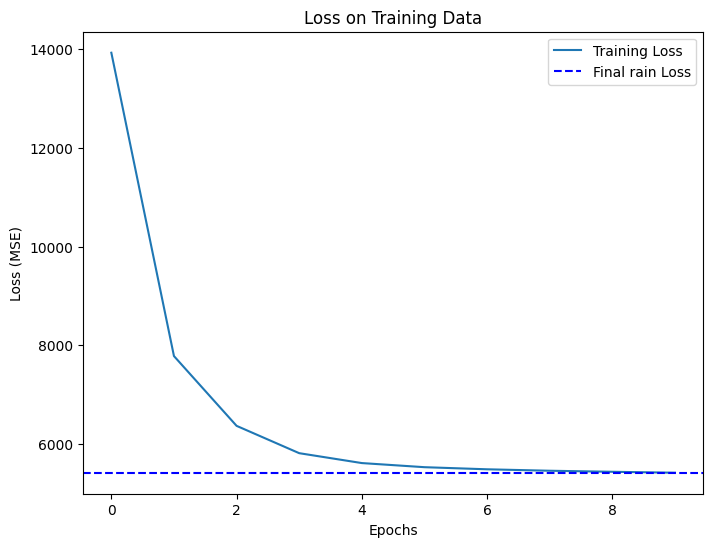

Final Training Loss (MSE): 5401.103547913347


In [33]:
# Calculate training loss
train_predictions = model.predict(X_train)
train_loss = np.mean((y_train - train_predictions.flatten())**2)

# Plot training loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')  # Training loss during epochs
plt.axhline(y=train_loss, color='blue', linestyle='--', label='Final rain Loss')  # Final training loss
plt.title('Loss on Training Data')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

print(f"Final Training Loss (MSE): {train_loss}")

In [36]:
print("X_seq shape (train):", X_seq.shape)  # Should be (samples, window, features)
print("X_test_seq shape (test):", X_test_seq.shape)
print("Train features:", train.drop(['pm2.5', 'No'], axis=1).columns.tolist())
print("Test features:", features)

X_seq shape (train): (30670, 6, 9)
X_test_seq shape (test): (13142, 6, 10)
Train features: ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv', 'TEMP_roll3']
Test features: ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv', 'TEMP_roll3']


In [55]:
# Prepare the test data for LSTM (must match training window size and features)

features = ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv']  # 9 features, matching X_seq

def create_test_sequences(X, window=6):
    Xs = []
    for i in range(len(X) - window):
        Xs.append(X.iloc[i:(i+window)].values)
    return np.array(Xs)

window_size = 6  # Use the same window size as in training
X_test_seq = create_test_sequences(test[features], window=window_size)

# Make predictions on the test set
predictions = model.predict(X_test_seq)
predictions = np.nan_to_num(predictions)
predictions = np.round(predictions).astype(int).flatten()

# Load sample submission to get correct row IDs and order
sample_submission_path = 'c:/Users/HP/Time-Series-Forecasting/Datasets/sample_submission .csv'
import os
if not os.path.exists(sample_submission_path):
    raise FileNotFoundError(f"Sample submission file not found at {sample_submission_path}. Please download it from Kaggle and place it in the Datasets folder.")

sample_submission = pd.read_csv(sample_submission_path)

# Pad predictions at the top with zeros if needed (for initial window_size rows)
if len(predictions) < len(sample_submission):
    pad_len = len(sample_submission) - len(predictions)
    predictions = np.concatenate([np.zeros(pad_len), predictions])
elif len(predictions) > len(sample_submission):
    predictions = predictions[-len(sample_submission):]

# Fill the pm2.5 column in the sample submission
sample_submission['pm2.5'] = predictions.astype(int)

print(sample_submission.head())
# Save the file in CSV format for submission on Kaggle
sample_submission.to_csv('c:/Users/HP/Time-Series-Forecasting/Datasets/submission.csv', index= False)

411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
               row ID  pm2.5
0  2013-07-02 4:00:00      0
1  2013-07-02 5:00:00      0
2  2013-07-02 6:00:00      0
3  2013-07-02 7:00:00      0
4  2013-07-02 8:00:00      0


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


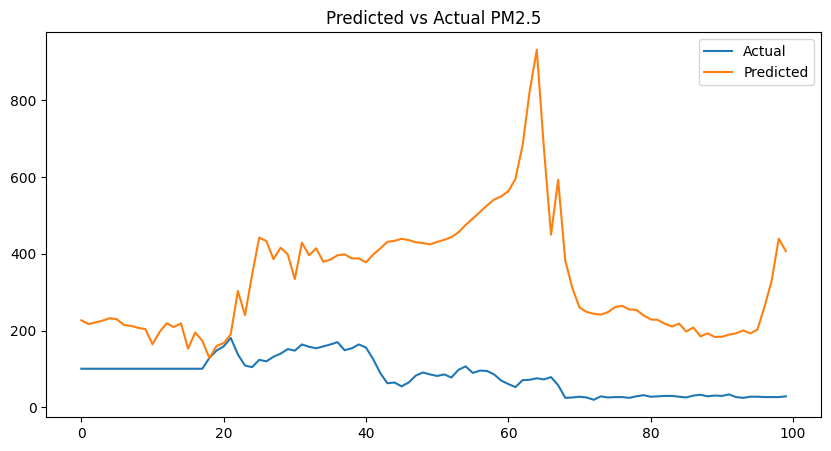

In [56]:
# Plot predicted vs actual PM2.5 for first 100 samples
plt.figure(figsize=(10,5))
plt.plot(y_seq[:100], label='Actual')
plt.plot(model.predict(X_seq[:100]), label='Predicted')
plt.legend()
plt.title('Predicted vs Actual PM2.5')
plt.show()